In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm

## Stock et période étudiée

In [2]:
tick = 'NVDA'
period = 'ytd'
interval = '1d'
dt = 1/360 

## Basic functions

In [3]:
def d1(S, K, t, r, vol):
    res = (np.log(S/K) + (r+0.5*vol**2)*t)/(vol*np.sqrt(t))
    return res

def d2(S, K, t, r, vol):
    return d1(S, K, t, r, vol) - vol*np.sqrt(t)

def N(x):
    return st.norm.cdf(x, loc=0, scale=1)

def call(S, K, T, r, vol):
    """
    Fonction qui renvoit le prix théorique d'un call de paramètres: S, K, T, r, vol
    """
    c = S*N(d1(S, K, T, r, vol)) - K*np.exp(-r*T)*N(d2(S, K, T, r, vol))
    return c

In [4]:
def get_spot(tick, period):
    """
    Fonction qui renvoit l'historique des closes d'un ticker
    """
    ticker = yf.Ticker(tick)
    data = ticker.history(period, interval)
    data = data[['Close']]
    return data

def get_vol_yield(tick, period):
    """
    Fonction qui renvoit la [vol historique, rendement] d'un ticker sur une periode
    """
    data = get_spot(tick, period)
    
    # Création de log(Stk/Stk-1)
    data['Y'] = np.log(data['Close']/data['Close'].shift(1))
    data = data.dropna()

    # Calcul des parametres
    nu = data['Y'].mean()/dt
    var = data['Y'].var()/dt
    vol = np.sqrt(var)
    mu = nu + 0.5*var
    return [vol, mu]

def Vol(tick, period):
    """
    Fonction qui renvoit la volatilité historique sur une période données
    """
    return get_vol_yield(tick, period)[0]

def Yield(tick, period):
    """
    Fonction qui renvoit le rendement sur une période données
    """
    return get_vol_yield(tick, period)[1]

def complete_years(data):
    # Obtenir la liste des années dans l'ordre
    min_year, max_year = min(data.keys()), max(data.keys())
    for year in range(min_year, max_year + 1):
        if year not in data:
            data[year] = data[year - 1]
    return dict(sorted(data.items()))


def rf_rate(year):
    """
    Fonction qui renvoit le taux sans risque en vigueur à l'année 'year'
    """
    df = pd.read_csv('ECB_Data.csv', sep=';')
    df = df[['YEAR', 'RATE']]
    df_pivot = df.groupby(by='YEAR', as_index=False).mean()
    dic_rate = complete_years(dict(zip(list(df_pivot['YEAR']), list(df_pivot['RATE']))))
    if year in dic_rate.keys():
        return dic_rate[year]
    else:
        return 'Wrong year'


def d1(S, K, t, r, vol):
    res = (np.log(S/K) + (r+0.5*vol**2)*t)/(vol*np.sqrt(t))
    return res

def d2(S, K, t, r, vol):
    return d1(S, K, t, r, vol) - vol*np.sqrt(t)

def N(x):
    return st.norm.cdf(x, loc=0, scale=1)

def call(S, K, T, r, vol):
    """
    Fonction qui renvoit le prix théorique d'un call de paramètres: S, K, T, r, vol
    """
    c = S*N(d1(S, K, T, r, vol)) - K*np.exp(-r*T)*N(d2(S, K, T, r, vol))
    return c



def monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations=10000, mode='simple'): 
    """
    Fonction qui estime le prix d'un call de param S0, K, T, r, sigma via Monte Carlo
    mode:
    
    """
    discount_factor = np.exp(-r*T)  
    Z = st.norm.rvs(loc=0, scale=1, size=num_simulations)
    ST = S0 * np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoffs = discount_factor*np.maximum(ST-K, 0)
 
    if mode == 'simple':
        option_price = np.mean(payoffs)
        option_var = np.var(payoffs, ddof=1)
    elif mode == 'CV':
        Y = discount_factor*payoffs
        X = ST
        EX = S0*np.exp(r*T)
        Cov_XY = np.cov(X, Y)[0, 1]
        Var_X = S0**2 * np.exp(2*r*T)*(np.exp(sigma**2*T) - 1)
        beta = Cov_XY/Var_X
        payoffs_CV = payoffs - beta*(X - EX)
        option_price = np.mean(payoffs_CV)
        option_var = np.var(payoffs_CV, ddof=1)
    return [option_price, option_var]
        
        
              

def calculate_z(alpha):
    """
    Calcule z_{alpha/2} pour un niveau de confiance donné alpha.
    """
    alpha_div_2 = alpha / 2
    z_alpha_div_2 = norm.ppf(1 - alpha_div_2)
    return z_alpha_div_2

def IC_MC(E, Var, n, alpha):
    z = calculate_z(alpha)
    std_error = np.sqrt(Var / n)
    return [E - z*std_error, E + z*std_error]

## Monte Carlo Simple

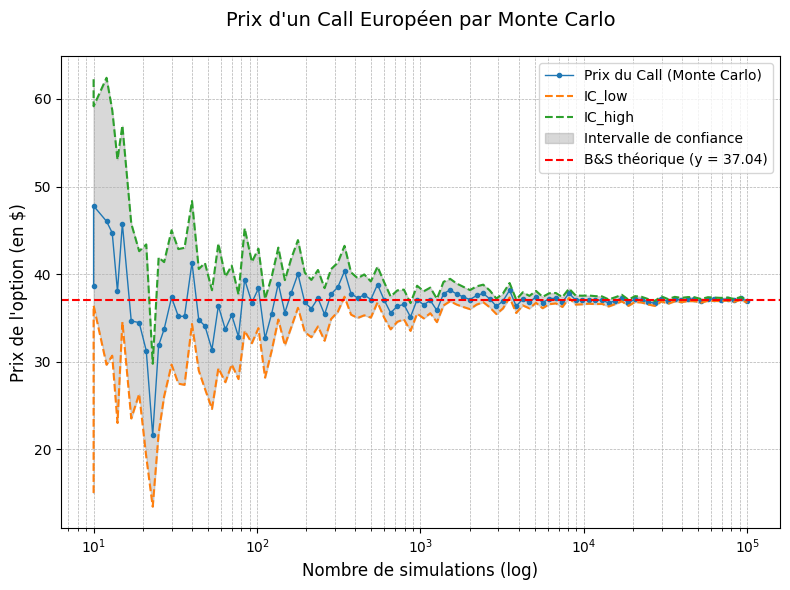

In [5]:
# Paramètres du call
data = get_spot(tick, period)
S =  data['Close'].iloc[-1] # On prend le spot d'aujourd'hui
K = S  # On se place at the money    
T = 1/12   # Maturité 
r = rf_rate(2024)  #Taux sans risque actuel
sigma = Vol(tick, period)  #On prend la vol historique calculée précédemment (avec les données ytd)
alpha = 0.05

# Prix théorique du call
c = call(S, K, T, r, sigma)

# Monte Carlo pour différentes valeurs de num_simulations
x_axis = np.logspace(1, 5, num=100, dtype=int) #log liste de valeurs allant de 10 à 100 000
y_axis = np.zeros_like(x_axis, dtype=float)
y_IC_low = np.zeros_like(x_axis, dtype=float)
y_IC_high = np.zeros_like(x_axis, dtype=float)
L_Var = np.zeros_like(x_axis, dtype=float)

for i,x in enumerate(x_axis):
    n = int(x)
    [X, Var] = monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations=n, mode='simple')
    IC = IC_MC(X, Var, n, alpha)
    y_axis[i] = X
    y_IC_low[i] = IC[0]
    y_IC_high[i] = IC[1]
    L_Var[i] = Var
    
# Création d'un graphique
plt.figure(figsize=(8, 6))
plt.plot(x_axis, y_axis, label="Prix du Call (Monte Carlo)", linewidth=1, marker='.')
plt.plot(x_axis, y_IC_low, label="IC_low", linestyle='--')
plt.plot(x_axis, y_IC_high, label="IC_high", linestyle='--')
plt.fill_between(x_axis, y_IC_low, y_IC_high, color='gray', alpha=0.3, label="Intervalle de confiance")
plt.axhline(y=c, color='red', linestyle='--', label=f"B&S théorique (y = {round(c,2)})")  # Ligne rouge horizontale
plt.xscale('log')  # Échelle logarithmique pour l'axe des abscisses
plt.xlabel("Nombre de simulations (log)", fontsize=12)
plt.ylabel("Prix de l'option (en $)", fontsize=12)
plt.title("Prix d'un Call Européen par Monte Carlo\n", fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=10)
plt.tight_layout()

## Monte Carlo Control Variate

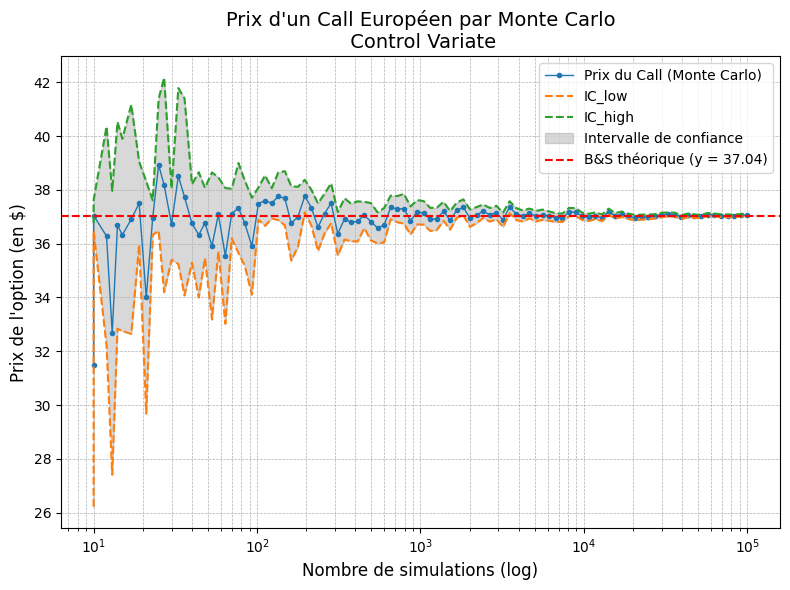

In [6]:
y_MC = np.zeros_like(x_axis, dtype=float)
y_MC_CV = np.zeros_like(x_axis, dtype=float)
L_Var_MC = np.zeros_like(x_axis, dtype=float)
L_Var_MC_CV = np.zeros_like(x_axis, dtype=float)
y_IC_CV_low = np.zeros_like(x_axis, dtype=float)
y_IC_CV_high = np.zeros_like(x_axis, dtype=float)

for i,x in enumerate(x_axis):
    n = int(x)
    [X, Var] = monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations=n, mode = 'simple')
    y_MC[i] = X
    L_Var_MC[i] = Var
    
    [X_CV, Var_CV] = monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations=n, mode = 'CV')
    y_MC_CV[i] = X_CV
    L_Var_MC_CV[i] = Var_CV
    IC = IC_MC(X_CV, Var_CV, n, alpha)
    y_IC_CV_low[i] = IC[0]
    y_IC_CV_high[i] = IC[1]


# Création d'un graphique
plt.figure(figsize=(8, 6))
plt.plot(x_axis, y_MC_CV, label="Prix du Call (Monte Carlo)", linewidth=1, marker='.')
plt.plot(x_axis, y_IC_CV_low, label="IC_low", linestyle='--')
plt.plot(x_axis, y_IC_CV_high, label="IC_high", linestyle='--')
plt.fill_between(x_axis, y_IC_CV_low, y_IC_CV_high, color='gray', alpha=0.3, label="Intervalle de confiance")
plt.axhline(y=c, color='red', linestyle='--', label=f"B&S théorique (y = {round(c,2)})")  # Ligne rouge horizontale
plt.xscale('log')  # Échelle logarithmique pour l'axe des abscisses
plt.xlabel("Nombre de simulations (log)", fontsize=12)
plt.ylabel("Prix de l'option (en $)", fontsize=12)
plt.title("Prix d'un Call Européen par Monte Carlo\n Control Variate", fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=10)
plt.tight_layout()





## Comparaison des variances avec MC simple

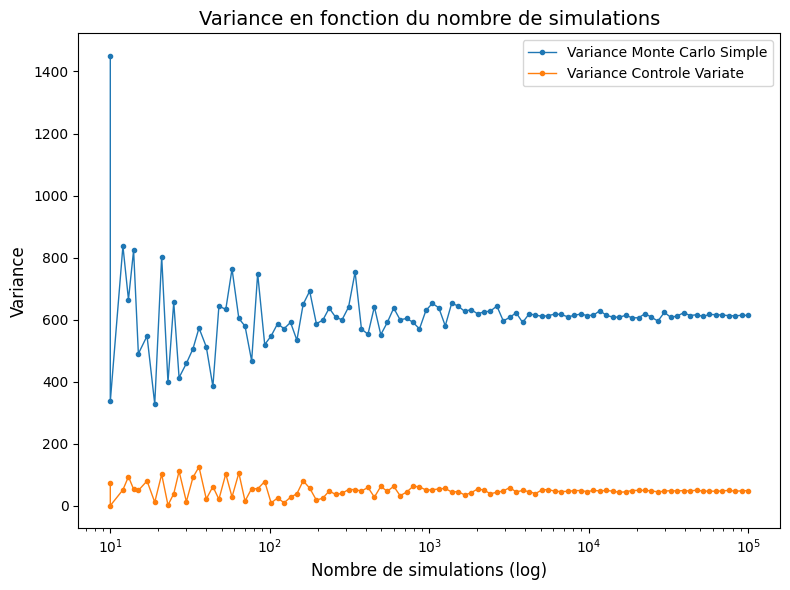

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(x_axis, L_Var, label="Variance Monte Carlo Simple", linewidth=1, marker='.')
plt.plot(x_axis, L_Var_MC_CV, label="Variance Controle Variate", linewidth=1, marker='.')
plt.xscale('log')  # Échelle logarithmique pour l'axe des abscisses
plt.xlabel("Nombre de simulations (log)", fontsize=12)
plt.ylabel("Variance", fontsize=12)
plt.title("Variance en fonction du nombre de simulations", fontsize=14)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=10)
plt.tight_layout()

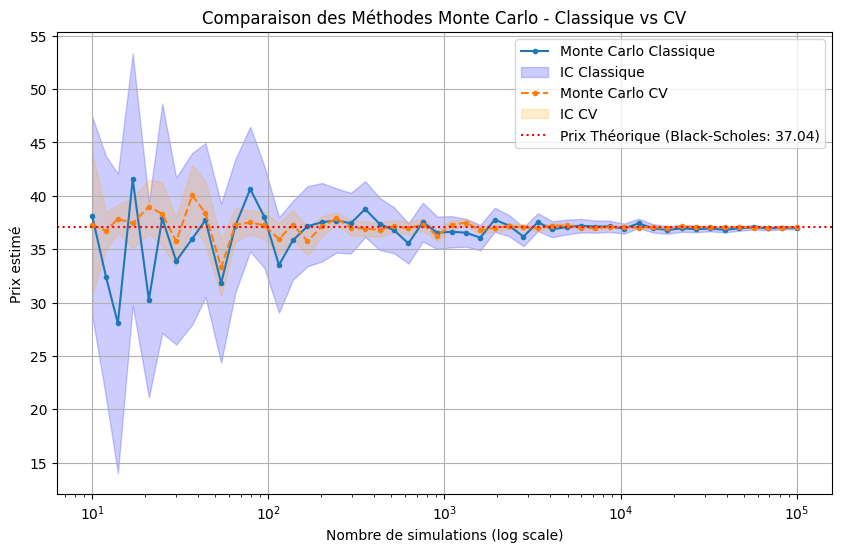

In [8]:
# Monte Carlo pour différentes valeurs de num_simulations
x_axis = np.logspace(1, 5, num=50, dtype=int)
y_axis_simple = np.zeros_like(x_axis, dtype=float)
y_IC_low_simple = np.zeros_like(x_axis, dtype=float)
y_IC_high_simple = np.zeros_like(x_axis, dtype=float)

y_axis_cv = np.zeros_like(x_axis, dtype=float)
y_IC_low_cv = np.zeros_like(x_axis, dtype=float)
y_IC_high_cv = np.zeros_like(x_axis, dtype=float)

for i, n in enumerate(x_axis):
    # Méthode simple
    price_simple, var_simple = monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations=n, mode='simple')
    IC_simple = IC_MC(price_simple, var_simple, n, alpha)
    y_axis_simple[i] = price_simple
    y_IC_low_simple[i] = IC_simple[0]
    y_IC_high_simple[i] = IC_simple[1]

    # Méthode CV
    price_cv, var_cv = monte_carlo_option_pricing(S, K, T, r, sigma, num_simulations=n, mode='CV')
    IC_cv = IC_MC(price_cv, var_cv, n, alpha)
    y_axis_cv[i] = price_cv
    y_IC_low_cv[i] = IC_cv[0]
    y_IC_high_cv[i] = IC_cv[1]

# Tracé des résultats
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_axis_simple, label="Monte Carlo Classique", linestyle='-', marker='.')
plt.fill_between(x_axis, y_IC_low_simple, y_IC_high_simple, color='blue', alpha=0.2, label="IC Classique")
plt.plot(x_axis, y_axis_cv, label="Monte Carlo CV", linestyle='--', marker='.')
plt.fill_between(x_axis, y_IC_low_cv, y_IC_high_cv, color='orange', alpha=0.2, label="IC CV")
plt.axhline(y=c, color='red', linestyle=':', label=f"Prix Théorique (Black-Scholes: {c:.2f})")
plt.xscale('log')
plt.xlabel("Nombre de simulations (log scale)")
plt.ylabel("Prix estimé")
plt.title("Comparaison des Méthodes Monte Carlo - Classique vs CV")
plt.legend()
plt.grid()
plt.show()

## Importance sampling